In [1]:
import numpy as np
import scipy
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from markov_epidemic import *

## SIS Epidemic

Consider a network of $N$ individuals subject to an epidemic disease.
Let $X_i(t)$ be the health state of individual $i$ at time $t$, $0$ being "healthy", 1 being "infected", and $A$ the adjacency matrix of the underlying graph.

We assume the following random Markov dynamic:

$$
\begin{cases} 
      0 \rightarrow 1 & \text{at rate $\beta\sum_j A_{ij} X_j(t)$,} \\
      1 \rightarrow 0 & \text{at rate $\delta$.} \\
   \end{cases}
$$

In other words, the infection rate of an individual is proportional to the number of infected neighbors in the network, and the recovery rate is constant. Also we assume only one individual can change state at a given time $t$ (the events of multiple simultaneous transitions has probability zero anyway).

Note that this is a Susceptible-Infected-Susceptible (SIS) model: the Markov property does not allow the process to "remember" its previous infectious states, and therefore individuals are likely to get sick again after having recovered.

### Network

/home/sauxpa/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


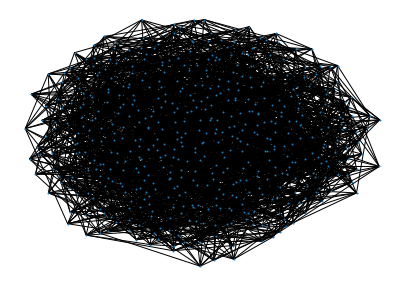

In [2]:
N = 500
G = nx.random_regular_graph(10, N)
# G = nx.complete_graph(N)
# G = nx.barabasi_albert_graph(N, 2)

# save layout
# pos = nx.shell_layout(G)
pos = nx.spring_layout(G)

fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)

nx.draw_networkx(G, pos=pos, ax=ax, with_labels=False, node_size=1)
ax.axis('off')

plt.show()

### Epidemic parameters

In [3]:
infection_rate = 1.0
recovery_rate = 5.0

epidemic = MarkovSIS(infection_rate, recovery_rate, G)

### Adjacency spectrum

The **effective diffusion rate** is $\rho = \frac{\beta}{\delta}$:
* $\rho > 1$: people get infected by a single neighbor faster than they recover,
* $\rho < 1$: people recover faster.

The duration and strength of the epidemic depends on this effective diffusion rate but also on the topology of the underlying social network.

The model being a Markov process on a finite set of states with an absorbing states (the configuration where no individual is ill), it is guaranteed that the process will eventually converge to this steady state. The question that remains is how fast is this convergence.

A result in [The Effect of Network Topology on the Spread ofEpidemics](https://people.maths.bris.ac.uk/~maajg/infocom-worm.pdf) shows that the inverse of the spectral radius of the adjacency matrix $\rho(A) = \max_{\lambda\in Spec(A)}|\lambda|$ is a threshold for a phase transition in the epidemic behaviour. Let $T_{extinction}$ the stopping time of the epidemic:

* if $\rho < \frac{1}{\rho(A)}$, then $\mathbb{E}[T_{extinction}] = \mathcal{O}\big( \log N\big)$
* if $\rho \gg \frac{1}{\rho(A)}$, then $\mathbb{E}[T_{extinction}] = \mathcal{O}\big( e^{N^\alpha}\big)$, where $\alpha>0$ is a constant, and $\gg$ hides a dependency on the isoperimetric constant of the underlying graph.
 

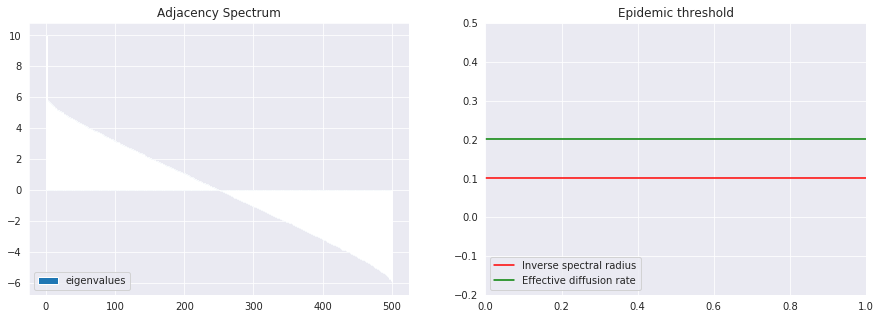

In [4]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

    ax = axes[0]
    ax.bar(range(1, N+1), epidemic.spectrum, label='eigenvalues')
    ax.set_title('Adjacency Spectrum')
    ax.legend(loc='lower left')
    
    ax = axes[1]
    isr = 1/epidemic.spectral_radius
    edr = epidemic.effective_diffusion_rate
    ax.axhline(y=isr, color='r', label='Inverse spectral radius')
    ax.axhline(y=edr, color='g', label='Effective diffusion rate')
    ax.set_xlim(0, 1)
    ax.set_ylim(np.min((edr, isr))-0.3, np.max((edr, isr))+0.3)
    ax.set_title('Epidemic threshold')
    ax.legend(loc='lower left')

    plt.show()

### Epidemic simulation

In [5]:
T = 10.0
x0 = np.zeros(N)

hub = list(G.node)[np.argmax(np.array(G.degree)[:, 1])]
x0[hub] = 1

epidemic.simulate(T, x0)

/home/sauxpa/github/epidemic/markov_epidemic/markov_epidemic.py:148: RuntimeWarning: divide by zero encountered in true_divide
  holding_times = np.random.exponential(scale=1/rates)


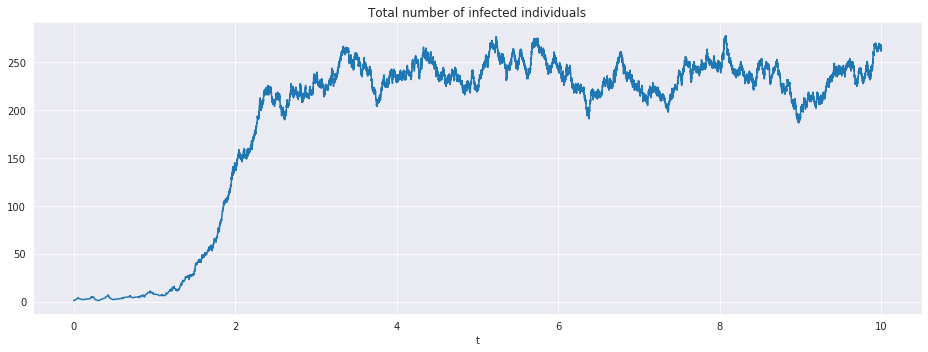

In [6]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(13, 5), nrows=1, ncols=1)

    ax.plot(epidemic.transition_times, epidemic.number_of_infected)
    ax.set_title('Total number of infected individuals')
    ax.set_xlabel('t')
    plt.tight_layout()
    plt.show()